# Training a Three-Layer Neural Network on Cifar-10

The tendril classification problem allowed us to use Neural Networks on a 2D toy dataset. In this notebook, we will work with an n-dimensional dataset of images. We will be using the famed [cifar-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), so that our  model can classify pictures of cars, planes, cats, dogs, frogs, and other items. Each image has is an 32 pixels by 32 pixels RGB image of shape ``(3,32,32)``. Thus each image is a point or vector in $\mathbb{R}^{3072}$.

We will be training a three-layer neural network. Our loss function is the cross-entropy loss. The first two layers will use the ReLU activation function and the last layer will use softmax activation. 



#### The Model in Full
$f(X; W_{1}, W_{2}, b_{1}, b_{2}) = softmax(ReLU((ReLU(XW_{1} + b_{1})W_{2} + b_{2}))W_3+b_3)$

Loss:
- cross-entropy loss
  - $L_{i} = -\sum_{k=0}^{9}{p^{(i)}_{k} \log{q^{(i)}_{k}}}$
 
 > $p^{(i)}$ is the **true** probability-distribution for classification. E.g. $p^{(i)}= (1, 0, ..., 0)$
    if datum $i$ is a car.
    
 > $q^{(i)}$ is the **predicted** probability-distribution for classification. E.g. $q^{(i)} = (0.8, 0.1, ..., 0)$ predicts that datum $i$ is a car with a 80% probability.


In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt

try:
    from jupyterthemes import jtplot
    jtplot.style()
except ImportError:
    pass

import mygrad as mg
import numpy as np

In [4]:
import datasets
datasets.download_cifar10()
x_train, y_train, x_test, y_test = datasets.load_cifar10()

print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)
print(x_train.dtype)

File already exists:
	/home/fish/datasets/cifar-10-python.npz
cifar-10 loaded
Training data shape:  (50000, 3, 32, 32)
Training labels shape:  (50000,)
Test data shape:  (10000, 3, 32, 32)
Test labels shape:  (10000,)
uint8


Plotting some sample images from each class.

<IPython.core.display.Javascript object>


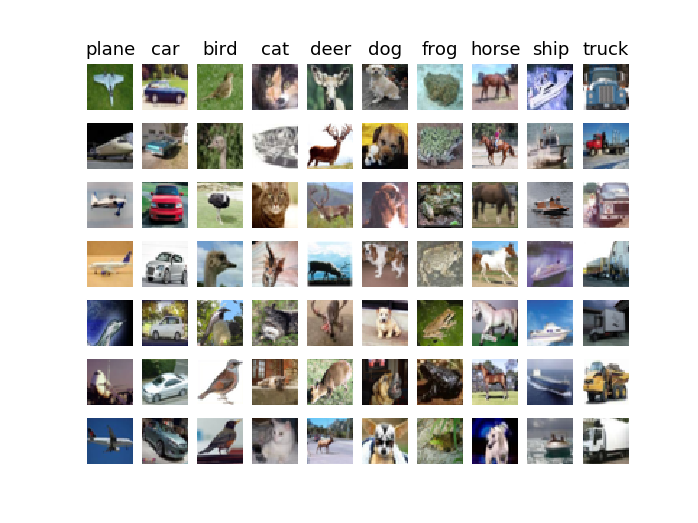

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].transpose(1,2,0).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Flatten out x_train and x_test and use ``astype`` to convert your data to ``np.float32``. Your ``(3,32,32)`` image should now be ``(3072,)``. Additionally, find the mean image and standard deviation image of the training and test data. Then, zero center your data by subtracting the mean image and normalize by dividing out by the standard deviation image. 

In [12]:
x_train = (x_train.astype(np.float32)).reshape(-1, 3072)
img_avgs = np.mean(x_train, axis=1).reshape(-1, 1)
x_train -= img_avgs 
x_train /= np.std(x_train, axis=1).reshape(-1, 1)


y_train.shape

(50000,)

Now, let's construct our model using `MyNN` and define our accuracy function.

In [13]:
from mynn.initializers.he_normal import he_normal
from mynn.activations.relu import relu
from mynn.optimizers.sgd import SGD
from mynn.losses.cross_entropy import softmax_cross_entropy
from mynn.layers.dense import dense
from mygrad.nnet.activations import softmax
class Model:
    def __init__(self, o0, o1):
        # initialize the three dense layers with the appropriate input/output dimenions
        # use ``weight_initializer=he_normal``
        
        self.dense0 = dense(3072, o0, weight_initializer=he_normal)
        self.dense1 = dense(o0, o1, weight_initializer=he_normal)
        self.dense2 = dense(o1, num_classes, weight_initializer=he_normal)
        
        
    def __call__(self, x):
        ''' Forward data through the network.
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor], shape=(N, D)
            The data to forward through the network.
            
        Returns
        -------
        mygrad.Tensor, shape=(N, 1)
            The model outputs.
        '''
        # returns output of dense -> relu -> dense -> relu -> dense -> softmax three layer.
        first = relu(self.dense0(x))
        second = relu(self.dense1(first))
        return self.dense2(second)
        
    @property
    def parameters(self):
        ''' A convenience function for getting all the parameters of our model. '''
        return self.dense0.parameters + self.dense1.parameters + self.dense2.parameters


def accuracy(predictions, truth):
    """
    Returns the mean classification accuracy for a batch of predictions.
    
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(M, D)
        The scores for D classes, for a batch of M data points
    truth : numpy.ndarray, shape=(M,)
        The true labels for each datum in the batch: each label is an
        integer in [0, D)
    
    Returns
    -------
    float
    """
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)

<IPython.core.display.Javascript object>


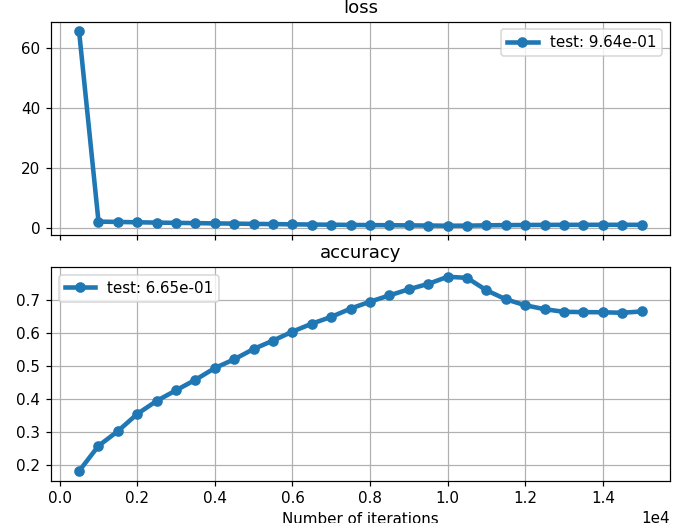

In [14]:
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

Initialize your model and optimizer, using SGD from MyNN. Specify the parameters, learning rate and weight_decay for your optimizer.

In [15]:
plotter.last_n_batches = int(2E3)

In [16]:
model = Model(1200, 800)

In [22]:
optim = SGD(model.parameters, learning_rate=0.1, weight_decay=.0005) 

Now write code to train your model! Experiment with your learning rate and weight_decay.

In [23]:
from mygrad.nnet.losses import softmax_crossentropy

# Set `batch_size = 100`: the number of predictions that we will make in each training step
batch_size = 100

# We will train for 10 epochs; you can change this if you'd like
for epoch_cnt in range(10):
    idxs = np.arange(len(x_train))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
    print(epoch_cnt)
    
    test_idxs = np.arange(len(x_test))
    
    for batch_cnt in range(0, len(x_train)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        
        batch = x_train[batch_indices]  # random batch of our training data

        # compute the predictions for this batch by calling on model
        prediction = model(batch)
        

        # compute the true (a.k.a desired) values for this batch: 
        truth = y_train[batch_indices]
        

        # compute the loss associated with our predictions(use softmax_cross_entropy)
        loss = softmax_crossentropy(prediction, truth)

        # back-propagate through your computational graph through your loss
        loss.backward()

        # compute the accuracy between the prediction and the truth 
        acc = accuracy(prediction, truth)
 

        # execute gradient descent by calling step() of optim
        optim.step()
        loss.null_gradients()
    
       
        plotter.set_test_batch({"accuracy" : acc, "loss" : loss.item()}, batch_size=batch_size)
        
    
    plotter.set_test_epoch()

0
1
2
3
4
5
6
7
8
9
